Current directory: d:\vscProjects\GA-ACO-SOPComparison\src

Available directories and files:
Directory: comparison_results
Directory: results
Directory: resultsACO
Found data directory: ../data
Running 10 trials for each algorithm on each instance...


Running experiments: 100%|██████████| 140/140 [10:29<00:00,  4.50s/it]



SUMMARY OF EXPERIMENTAL RESULTS

Cost Statistics (lower is better):
   algorithm   instance  cost_min  cost_mean    cost_std
0        ACO  ESC07.sop      2475     2490.0   24.152295
1        ACO  ESC11.sop      2288     2339.5   27.252931
2        ACO  ESC12.sop      1675     1684.0    3.162278
3        ACO  ESC25.sop      2085     2253.9  101.797675
4        ACO  ESC47.sop      2462     2716.3   96.994903
5        ACO  ESC63.sop        62       63.6    0.843274
6        ACO  ESC78.sop     19655    20049.5  313.346188
7         GA  ESC07.sop      2125     2167.5  134.396801
8         GA  ESC11.sop      2129     2212.4   54.039492
9         GA  ESC12.sop      1675     1747.9   25.899163
10        GA  ESC25.sop      2753     3396.2  544.491363
11        GA  ESC47.sop      4826     5924.7  705.835840
12        GA  ESC63.sop        85       96.5    7.337120
13        GA  ESC78.sop     20080    20544.5  401.001870

Time Statistics (seconds):
   algorithm   instance   time_min  time_mean  t

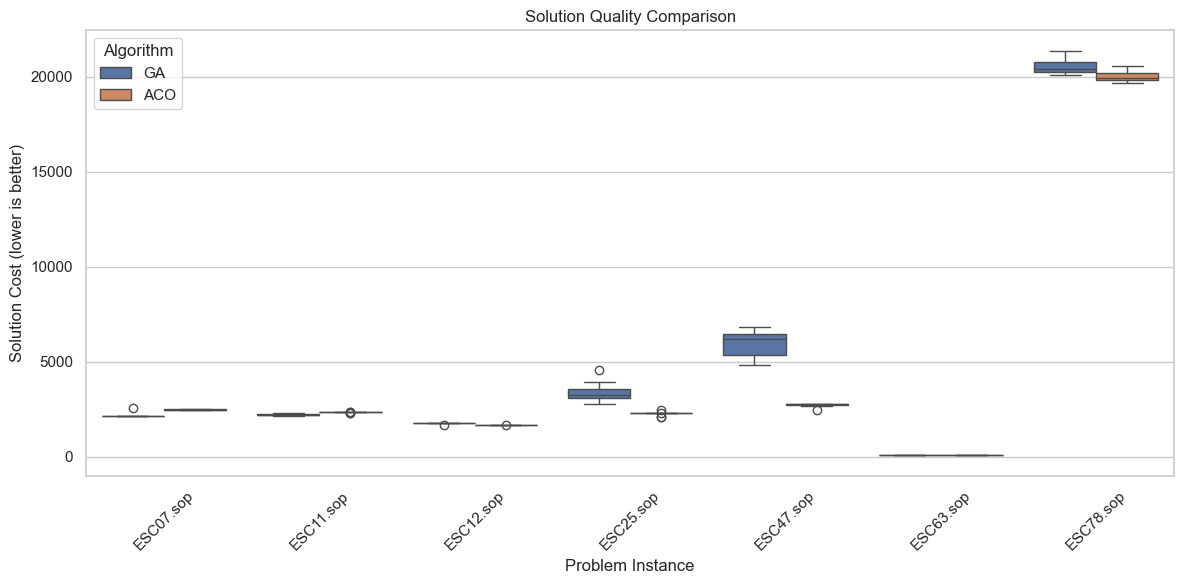

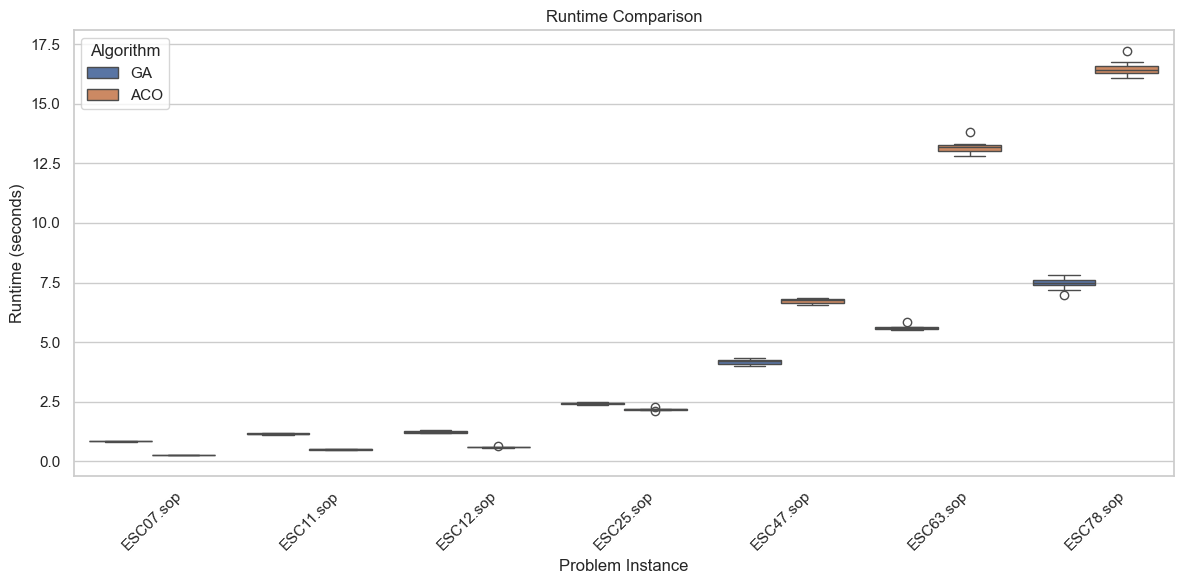

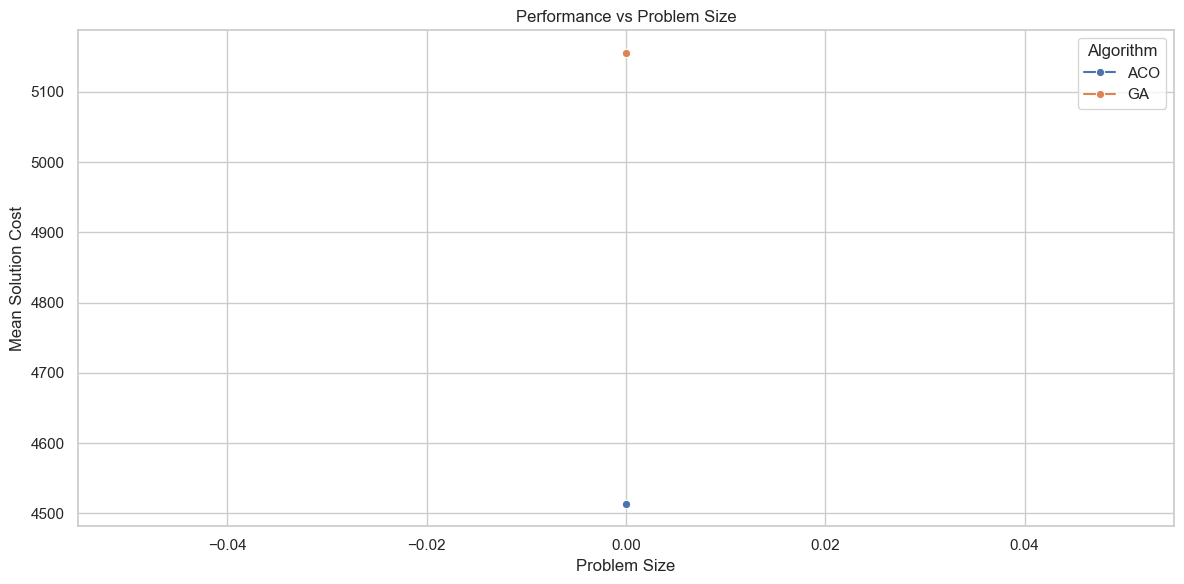

In [26]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

# SOP problem definition (shared by both algorithms)
class SOP:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file_name = Path(file_path).name
        self.nodes, self.costs, self.precedence = self.parse_file(file_path)
        self.size = len(self.nodes)
        # Create precedence graph for faster validation
        self.before = defaultdict(set)
        self.after = defaultdict(set)
        self.build_precedence_graph()

    def parse_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Extract dimension
        dimension = next(int(line.strip().split(':')[1]) 
                         for line in lines if line.startswith('DIMENSION'))
        
        # Find the start of matrix data
        matrix_start = next(i for i, line in enumerate(lines) 
                           if line.startswith('EDGE_WEIGHT_SECTION')) + 1
        
        # Skip the dimension line if present
        if lines[matrix_start].strip().isdigit():
            matrix_start += 1
        
        # Parse the matrix
        matrix_data = []
        for i in range(matrix_start, matrix_start + dimension):
            row = list(map(int, lines[i].strip().split()))
            matrix_data.append(row)
        
        # Convert to numpy array for faster operations
        costs_matrix = np.array(matrix_data)
        
        # Extract nodes and costs
        nodes = list(range(1, dimension + 1))
        costs = {}
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] != -1:
                    costs[(i+1, j+1)] = costs_matrix[i, j]
        
        # Extract precedence constraints (wherever there's a -1)
        precedence = []
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] == -1 and i != j:
                    precedence.append((j+1, i+1))  # j must come before i
        
        return nodes, costs, precedence

    def build_precedence_graph(self):
        for u, v in self.precedence:
            self.before[v].add(u)
            self.after[u].add(v)
        
        # Transitive closure - if a→b and b→c then a→c
        changed = True
        while changed:
            changed = False
            for node in self.nodes:
                old_before = self.before[node].copy()
                for b in old_before:
                    self.before[node].update(self.before[b])
                if len(self.before[node]) > len(old_before):
                    changed = True
                    
                old_after = self.after[node].copy()
                for a in old_after:
                    self.after[node].update(self.after[a])
                if len(self.after[node]) > len(old_after):
                    changed = True

    def is_valid(self, path):
        position = {node: i for i, node in enumerate(path)}
        
        # Check precedence constraints
        for i, node in enumerate(path):
            for before_node in self.before[node]:
                if before_node in position and position[before_node] >= i:
                    return False
                    
        # Check if costs exist between adjacent nodes
        for i in range(len(path) - 1):
            if (path[i], path[i+1]) not in self.costs:
                return False
                
        return True

    def total_cost(self, path):
        return sum(self.costs.get((path[i], path[i+1]), float('inf')) 
                  for i in range(len(path) - 1))

# Genetic Algorithm Implementation
class GeneticSolver:
    def __init__(self, sop, pop_size=50, generations=100, 
                 mutation_rate=0.15, elite_size=5):
        self.sop = sop
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.population = []
        self.best_solution = None
        self.best_cost = float('inf')
        self.generation_stats = []

    def create_initial_population(self):
        self.population = []
        
        # Get mandatory start and end nodes
        start_candidates = [n for n in self.sop.nodes if not self.sop.before[n]]
        end_candidates = [n for n in self.sop.nodes if not self.sop.after[n]]
        
        start_node = start_candidates[0] if start_candidates else 1
        end_node = end_candidates[0] if end_candidates else self.sop.size
        
        while len(self.population) < self.pop_size:
            path = self.generate_valid_path(start_node, end_node)
            if path:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()

    def generate_valid_path(self, start_node, end_node):
        path = [start_node]
        remaining = set(self.sop.nodes) - {start_node, end_node}
        
        current_node = start_node
        max_attempts = 100
        attempts = 0
        
        while remaining and attempts < max_attempts:
            # Find valid next nodes
            candidates = [n for n in remaining if 
                         self.sop.before[n].issubset(set(path)) and
                         (current_node, n) in self.sop.costs]
            
            if not candidates:
                # Backtrack or restart
                attempts += 1
                if attempts >= max_attempts:
                    return None
                path = [start_node]
                remaining = set(self.sop.nodes) - {start_node, end_node}
                current_node = start_node
                continue
                
            # Choose random next node with preference for lower cost
            costs = [self.sop.costs.get((current_node, n), float('inf')) for n in candidates]

            # Inverse costs for weighted selection
            weights = [1/(c+1) for c in costs]
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(candidates, weights=weights, k=1)[0]
            path.append(next_node)
            remaining.remove(next_node)
            current_node = next_node
            
        if not remaining:
            path.append(end_node)
            return path
        return None

    def select_parents(self):
        # Calculate fitness (inverse of cost)
        costs = [self.sop.total_cost(path) for path in self.population]
        fitness = [1/(1+cost) for cost in costs]
        
        # Select two parents using tournament selection
        def tournament():
            candidates = random.sample(range(self.pop_size), 3)
            return self.population[max(candidates, key=lambda i: fitness[i])]
            
        return tournament(), tournament()

    def ordered_crossover(self, parent1, parent2):
        size = len(parent1)
        
        # Select a random segment
        start, end = sorted(random.sample(range(size), 2))
        
        # Create child with segment from parent1
        child = [None] * size
        child[start:end+1] = parent1[start:end+1]
        
        # Fill remaining positions with genes from parent2
        remaining = [gene for gene in parent2 if gene not in child]
        
        # Fill before segment
        idx = 0
        for i in range(start):
            child[i] = remaining[idx]
            idx += 1
            
        # Fill after segment
        for i in range(end+1, size):
            child[i] = remaining[idx]
            idx += 1
        
        # Repair if needed
        if not self.sop.is_valid(child):
            child = self.repair(child)
            
        return child

    def repair(self, path):
        valid_path = []
        
        # Reconstruct topological order based on precedence
        candidates = set(path)
        while candidates:
            # Find nodes with no remaining predecessors
            ready = [n for n in candidates 
                    if all(pred not in candidates for pred in self.sop.before[n])]
            
            if not ready:
                # Circular dependency detected - break it arbitrarily
                ready = [next(iter(candidates))]
                
            # Select node by original order in path
            next_node = min(ready, key=lambda n: path.index(n))
            valid_path.append(next_node)
            candidates.remove(next_node)
            
        return valid_path

    def mutate(self, path):
        if random.random() > self.mutation_rate:
            return path
            
        # Make a copy to avoid modifying the original
        mutated = path.copy()
        
        # Try to find a valid swap
        max_attempts = 20
        for _ in range(max_attempts):
            i, j = sorted(random.sample(range(len(path)), 2))
            
            # Try the swap
            mutated[i], mutated[j] = mutated[j], mutated[i]
            
            # Check if valid
            if self.sop.is_valid(mutated):
                return mutated
                
            # Revert if invalid
            mutated[i], mutated[j] = mutated[j], mutated[i]
            
        return path  # Return original if no valid mutation found

    def evolve(self):
        new_population = []
        
        # Sort population by fitness (ascending cost)
        sorted_pop = sorted(self.population, 
                          key=lambda p: self.sop.total_cost(p))
        
        # Elitism - keep best solutions
        new_population.extend(sorted_pop[:self.elite_size])
        
        # Fill the rest with crossover and mutation
        while len(new_population) < self.pop_size:
            parent1, parent2 = self.select_parents()
            child = self.ordered_crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)
            
        self.population = new_population
        
        # Update best solution
        current_best = min(self.population, key=self.sop.total_cost)
        current_cost = self.sop.total_cost(current_best)
        
        if current_cost < self.best_cost:
            self.best_cost = current_cost
            self.best_solution = current_best.copy()
            
        # Record statistics
        self.generation_stats.append({
            'generation': len(self.generation_stats),
            'best_cost': self.best_cost,
            'avg_cost': np.mean([self.sop.total_cost(p) for p in self.population]),
            'min_cost': current_cost
        })

    def solve(self, verbose=False):
        start_time = time.time()
        
        self.create_initial_population()
        
        for gen in range(self.generations):
            self.evolve()
            
            # Print progress periodically
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}/{self.generations}, " 
                      f"Best cost: {self.best_cost}")
                
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'algorithm': 'GA',
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'generations': self.generations,
            'stats': self.generation_stats
        }

# Ant Colony Optimization Implementation
class AntColonySolver:
    def __init__(self, sop, ants=50, iterations=100, 
                 alpha=1.0, beta=2.0, rho=0.1, q0=0.9,
                 initial_pheromone=0.1, local_decay=0.1):
     
        self.sop = sop
        self.ants = ants
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.initial_pheromone = initial_pheromone
        self.local_decay = local_decay
        
        # Initialize pheromone matrix
        self.pheromone = {}
        for i in self.sop.nodes:
            for j in self.sop.nodes:
                if (i, j) in self.sop.costs:
                    self.pheromone[(i, j)] = initial_pheromone
        
        # Heuristic information (inverse of cost)
        self.heuristic = {}
        for (i, j), cost in self.sop.costs.items():
            self.heuristic[(i, j)] = 1.0 / cost if cost > 0 else 0.0
        
        # Best solution tracking
        self.best_solution = None
        self.best_cost = float('inf')
        self.iteration_stats = []
    
    def construct_solution(self):
        """
        Construct a solution for a single ant using the ACO approach
        with precedence constraints
        """
        # Start with a valid starting node
        unvisited = set(self.sop.nodes)
        current_path = []
        
        # Find valid starting nodes (with no predecessors)
        valid_starts = [n for n in self.sop.nodes if not self.sop.before[n]]
        start_node = valid_starts[0] if valid_starts else 1
        
        current_node = start_node
        current_path.append(current_node)
        unvisited.remove(current_node)
        
        # Continue until all nodes are visited
        while unvisited:
            # Find feasible next nodes (those with all predecessors visited)
            feasible_nodes = []
            for node in unvisited:
                if all(pred not in unvisited for pred in self.sop.before[node]):
                    if (current_node, node) in self.sop.costs:
                        feasible_nodes.append(node)
            
            # If no feasible next nodes, we have a problem with the instance
            if not feasible_nodes:
                # Fallback strategy: choose any unvisited node
                for node in unvisited:
                    if (current_node, node) in self.sop.costs:
                        feasible_nodes.append(node)
                
                # If still no feasible nodes, choose any node
                if not feasible_nodes:
                    feasible_nodes = list(unvisited)
            
            # Apply ACO selection rule
            next_node = self.select_next_node(current_node, feasible_nodes)
            
            # Apply local pheromone update
            self.local_pheromone_update(current_node, next_node)
            
            # Move to next node
            current_path.append(next_node)
            current_node = next_node
            unvisited.remove(next_node)
        
        # Verify the path is valid
        if not self.sop.is_valid(current_path):
            current_path = self.repair_path(current_path)
            
        return current_path
    
    def select_next_node(self, current_node, feasible_nodes):
        """
        Select next node using ACO transition rule
        """
        if not feasible_nodes:
            return None
            
        # Exploitation (choose best) or exploration (probabilistic)
        if random.random() < self.q0:
            # Exploitation - choose best node
            return max(feasible_nodes, 
                      key=lambda j: self.pheromone.get((current_node, j), 0) ** self.alpha * 
                                   self.heuristic.get((current_node, j), 0) ** self.beta)
        else:
            # Exploration - probabilistic choice
            total = 0
            probabilities = []
            
            for node in feasible_nodes:
                prob = (self.pheromone.get((current_node, node), 0) ** self.alpha * 
                       self.heuristic.get((current_node, node), 0) ** self.beta)
                probabilities.append(prob)
                total += prob
            
            # Normalize probabilities
            if total > 0:
                probabilities = [p/total for p in probabilities]
            else:
                # If all probabilities are zero, use uniform distribution
                probabilities = [1.0/len(feasible_nodes)] * len(feasible_nodes)
            
            # Roulette wheel selection
            r = random.random()
            cumulative = 0
            for i, prob in enumerate(probabilities):
                cumulative += prob
                if r <= cumulative:
                    return feasible_nodes[i]
            
            # Fallback
            return random.choice(feasible_nodes)
    
    def local_pheromone_update(self, i, j):
        """
        Apply local pheromone update rule
        τ(i,j) = (1-ξ) * τ(i,j) + ξ * τ0
        """
        if (i, j) in self.pheromone:
            self.pheromone[(i, j)] = ((1 - self.local_decay) * self.pheromone[(i, j)] + 
                                     self.local_decay * self.initial_pheromone)
    
    def global_pheromone_update(self, best_path, best_cost):
        """
        Apply global pheromone update rule
        τ(i,j) = (1-ρ) * τ(i,j) + ρ * Δτ(i,j)
        where Δτ(i,j) = 1/L if (i,j) belongs to best path, 0 otherwise
        """
        # Evaporation
        for i, j in self.pheromone:
            self.pheromone[(i, j)] *= (1 - self.rho)
        
        # Reinforcement for best path
        for i in range(len(best_path) - 1):
            edge = (best_path[i], best_path[i+1])
            if edge in self.pheromone:
                delta = 1.0 / best_cost if best_cost > 0 else 0
                self.pheromone[edge] += self.rho * delta
    
    def repair_path(self, path):
        """
        Repair a path to satisfy precedence constraints
        """
        # Create a valid ordering based on precedence constraints
        valid_path = []
        nodes_to_place = set(path)
        
        while nodes_to_place:
            # Find nodes with all precedence constraints satisfied
            valid_candidates = [n for n in nodes_to_place 
                              if all(pred in valid_path for pred in self.sop.before[n])]
            
            # If no valid candidates, there's a cycle - break it
            if not valid_candidates:
                # Choose a node arbitrarily
                next_node = next(iter(nodes_to_place))
            else:
                # Choose a node with the earliest position in the original path
                next_node = min(valid_candidates, key=lambda n: path.index(n))
            
            valid_path.append(next_node)
            nodes_to_place.remove(next_node)
            
        return valid_path
    
    def solve(self, verbose=False):
        """
        Main solving method for the ACO algorithm
        """
        start_time = time.time()
        
        # Iterations of the ACO algorithm
        for it in range(self.iterations):
            iteration_best_cost = float('inf')
            iteration_best_path = None
            
            # Each ant constructs a solution
            for ant in range(self.ants):
                # Construct solution
                path = self.construct_solution()
                cost = self.sop.total_cost(path)
                
                # Update iteration best
                if cost < iteration_best_cost:
                    iteration_best_cost = cost
                    iteration_best_path = path.copy()
            
            # Update global best
            if iteration_best_cost < self.best_cost:
                self.best_cost = iteration_best_cost
                self.best_solution = iteration_best_path.copy()
            
            # Global pheromone update
            self.global_pheromone_update(self.best_solution, self.best_cost)
            
            # Record statistics
            self.iteration_stats.append({
                'iteration': it,
                'best_cost': self.best_cost,
                'iteration_best': iteration_best_cost,
                'avg_cost': iteration_best_cost  # Can be improved with multiple ants
            })
            
            # Display progress
            if verbose and (it % 10 == 0 or it == self.iterations - 1):
                print(f"Iteration {it}/{self.iterations}, Best cost: {self.best_cost}")
        
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'algorithm': 'ACO',
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'iterations': self.iterations,
            'stats': self.iteration_stats
        }

# SOP Comparison Framework
class SOPComparison:
    def __init__(self, data_dir="data", runs=10, results_dir="comparison_results"):
        self.data_dir = data_dir
        self.runs = runs
        self.results_dir = results_dir
        self.instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
        self.ensure_directories()
        
    def ensure_directories(self):
        """Create output directories if they don't exist"""
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(os.path.join(self.results_dir, "plots"), exist_ok=True)
        os.makedirs(os.path.join(self.results_dir, "data"), exist_ok=True)
    
    def run_single_experiment(self, instance, algorithm, run_id, verbose=False):
        """Run a single experiment with the specified algorithm"""
        file_path = os.path.join(self.data_dir, f"{instance}.sop")
        
        # Create SOP problem instance
        sop = SOP(file_path)
        
        if algorithm == 'GA':
            # Run Genetic Algorithm
            solver = GeneticSolver(sop, pop_size=50, generations=100)
        else:
            # Run Ant Colony Optimization
            solver = AntColonySolver(sop, ants=50, iterations=100)
        
        # Solve the problem
        result = solver.solve(verbose=verbose)
        result['run_id'] = run_id
        
        return result
    
    def run_all_experiments(self, parallel=True, max_workers=None):
        """Run all experiments for all instances and both algorithms"""
        all_results = []
        
        # Set up tasks
        tasks = []
        for instance in self.instances:
            for run_id in range(self.runs):
                tasks.append((instance, 'GA', run_id))
                tasks.append((instance, 'ACO', run_id))
        
        # Determine parallel execution
        if parallel and max_workers is None:
            max_workers = max(1, multiprocessing.cpu_count() - 1)
        
        if parallel and max_workers > 1:
            # Run in parallel
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                futures = []
                
                for instance, algorithm, run_id in tasks:
                    futures.append(executor.submit(
                        self.run_single_experiment, instance, algorithm, run_id, False
                    ))
                
                # Collect results as they complete
                for future in tqdm(futures, desc="Running experiments", total=len(futures)):
                    all_results.append(future.result())
        else:
            # Run sequentially
            for instance, algorithm, run_id in tqdm(tasks, desc="Running experiments"):
                result = self.run_single_experiment(instance, algorithm, run_id, False)
                all_results.append(result)
        
        return all_results
    
    def analyze_results(self, results):
        """Analyze results and generate reports"""
        # Create dataframe with experiment results
        summary_data = []
        for result in results:
            summary_data.append({
                'instance': result['instance'],
                'algorithm': result['algorithm'],
                'run_id': result['run_id'],
                'cost': result['cost'],
                'time': result['time']
            })
        
        df = pd.DataFrame(summary_data)
        
        # Save raw data
        df.to_csv(os.path.join(self.results_dir, "data", "experiment_results.csv"), index=False)
        
        # Calculate statistics by algorithm and instance
        stats = df.groupby(['algorithm', 'instance']).agg({
            'cost': ['min', 'mean', 'max', 'std'],
            'time': ['min', 'mean', 'max', 'std']
        }).reset_index()
        
        # Reshape for cleaner output
        stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats.columns.values]
        stats.to_csv(os.path.join(self.results_dir, "data", "result_statistics.csv"), index=False)
        
        # Create performance ratio tables
        pivot_cost = df.pivot_table(index='instance', columns='algorithm', values='cost', aggfunc='mean')
        pivot_cost['ratio'] = pivot_cost['ACO'] / pivot_cost['GA']
        
        pivot_time = df.pivot_table(index='instance', columns='algorithm', values='time', aggfunc='mean')
        pivot_time['ratio'] = pivot_time['ACO'] / pivot_time['GA']
        
        # Print summary
        print("\n" + "="*80)
        print("SUMMARY OF EXPERIMENTAL RESULTS")
        print("="*80)
        
        print("\nCost Statistics (lower is better):")
        print(stats[['algorithm', 'instance', 'cost_min', 'cost_mean', 'cost_std']])
        
        print("\nTime Statistics (seconds):")
        print(stats[['algorithm', 'instance', 'time_min', 'time_mean', 'time_std']])
        
        print("\nPerformance Ratio (ACO/GA) for Cost (lower is better for ACO):")
        print(pivot_cost['ratio'])
        
        print("\nPerformance Ratio (ACO/GA) for Time (lower is better for ACO):")
        print(pivot_time['ratio'])
        
        # Count wins
        ga_wins = sum(pivot_cost['ratio'] > 1)
        aco_wins = sum(pivot_cost['ratio'] < 1)
        ties = sum(pivot_cost['ratio'] == 1)
        
        print("\nWin counts (based on mean cost):")
        print(f"GA wins: {ga_wins}, ACO wins: {aco_wins}, Ties: {ties}")
        
        # Create visualizations
        self.visualize_results(df, results)
        
        return stats, pivot_cost, pivot_time
    
    def visualize_results(self, df, results):
        """Create visualizations of the experimental results"""
        sns.set(style="whitegrid")
        
        # 1. Solution quality comparison
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='instance', y='cost', hue='algorithm', data=df)
        plt.title('Solution Quality Comparison')
        plt.xlabel('Problem Instance')
        plt.ylabel('Solution Cost (lower is better)')
        plt.xticks(rotation=45)
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "solution_quality.png"), dpi=300)
        
        # 2. Runtime comparison
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='instance', y='time', hue='algorithm', data=df)
        plt.title('Runtime Comparison')
        plt.xlabel('Problem Instance')
        plt.ylabel('Runtime (seconds)')
        plt.xticks(rotation=45)
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "runtime.png"), dpi=300)
        
        # 3. Convergence plots for each instance
        for instance in df['instance'].unique():
            ga_results = [r for r in results if r['instance'] == instance and r['algorithm'] == 'GA']
            aco_results = [r for r in results if r['instance'] == instance and r['algorithm'] == 'ACO']
            
            if not ga_results or not aco_results:
                continue
                
            plt.figure(figsize=(12, 6))
            
            # Plot GA convergence
            for i, result in enumerate(ga_results):
                stats_df = pd.DataFrame(result['stats'])
                if i == 0:  # Only label the first one for cleaner legend
                    plt.plot(stats_df['generation'], stats_df['best_cost'], 'b-', alpha=0.3, label='GA Runs')
                else:
                    plt.plot(stats_df['generation'], stats_df['best_cost'], 'b-', alpha=0.3)
            
            # Plot ACO convergence
            for i, result in enumerate(aco_results):
                stats_df = pd.DataFrame(result['stats'])
                if i == 0:  # Only label the first one for cleaner legend
                    plt.plot(stats_df['iteration'], stats_df['best_cost'], 'r-', alpha=0.3, label='ACO Runs')
                else:
                    plt.plot(stats_df['iteration'], stats_df['best_cost'], 'r-', alpha=0.3)
            
            # Add mean convergence lines
            if ga_results:
                ga_avg = []
                for gen in range(100):  # Assuming all GA runs used 100 generations
                    costs = [r['stats'][gen]['best_cost'] for r in ga_results if gen < len(r['stats'])]
                    if costs:
                        ga_avg.append(np.mean(costs))
                plt.plot(range(len(ga_avg)), ga_avg, 'b-', linewidth=2, label='GA Mean')
            
            if aco_results:
                aco_avg = []
                for it in range(100):  # Assuming all ACO runs used 100 iterations
                    costs = [r['stats'][it]['best_cost'] for r in aco_results if it < len(r['stats'])]
                    if costs:
                        aco_avg.append(np.mean(costs))
                plt.plot(range(len(aco_avg)), aco_avg, 'r-', linewidth=2, label='ACO Mean')
            
            plt.title(f'Convergence Comparison for {instance}')
            plt.xlabel('Generation/Iteration')
            plt.ylabel('Best Solution Cost')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(self.results_dir, "plots", f"convergence_{instance}.png"), dpi=300)
            plt.close()
        
        # 4. Performance vs Problem Size
        # Extract problem sizes from instance names
        df['problem_size'] = df['instance'].apply(lambda x: int(x[3:]) if x[3:].isdigit() else 0)
        
        plt.figure(figsize=(12, 6))
        performance_data = df.groupby(['algorithm', 'problem_size']).agg({'cost': 'mean'}).reset_index()
        sns.lineplot(x='problem_size', y='cost', hue='algorithm', data=performance_data, marker='o')
        plt.title('Performance vs Problem Size')
        plt.xlabel('Problem Size')
        plt.ylabel('Mean Solution Cost')
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "performance_by_size.png"), dpi=300)
    
    def run_analysis(self):
        """Run the full comparison and analysis"""
        print(f"Running {self.runs} trials for each algorithm on each instance...")
        
        # Run sequentially to avoid process pool issues
        results = self.run_all_experiments(parallel=False)
        
        stats, pivot_cost, pivot_time = self.analyze_results(results)
        
        print("\nAnalysis completed!")
        print(f"Results saved to {self.results_dir}")
        
        return results, stats, pivot_cost, pivot_time

if __name__ == "__main__":
    # Get current directory path for reference
    current_dir = os.path.dirname(os.path.abspath("__file__"))
    print(f"Current directory: {current_dir}")
    
    # List available directories to help find data
    print("\nAvailable directories and files:")
    for item in os.listdir('.'):
        if os.path.isdir(item):
            print(f"Directory: {item}")
        elif item.endswith('.sop'):
            print(f"SOP file: {item}")
    
    # Try to locate SOP data files
    data_dir = "."  # Use current directory as default
    
    # Check if a specific data directory exists
    possible_data_dirs = ["data", "../data", "./data"]
    for dir_path in possible_data_dirs:
        if os.path.isdir(dir_path):
            print(f"Found data directory: {dir_path}")
            data_dir = dir_path
            break
    
    # Set up the comparison framework
    comparison = SOPComparison(
        data_dir=data_dir,  # Use the detected data directory
        runs=10,             # Reduced number of runs for testing
        results_dir="comparison_results"  # Output directory
    )
    
    # Limit to just a couple of instances for testing
    comparison.instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]  # Just the smallest instances
    
    # Run the comparison and analysis
    results, stats, pivot_cost, pivot_time = comparison.run_analysis()